# 2 ML Features Selection & Model Training

Runs:
- Study Load & Inspections [Jump To](#run-1-study-load--inspections)
- Feature Selection & Data Prep [Jump To](#run-2-feature-selection--data-prep)
- Model Training [Jump To](#run-3-model-training)
- Model Training with Combined Grid Search [Jump To](#run-4-models-training-with-combined-grid-search)


# Imports & Functions

## Imports

In [ ]:
# General imports
import os
import sys
import gc
import warnings
from typing import Literal

from datetime import datetime
from pprint import pprint
import time
import pickle
import cloudpickle
import random
from collections import Counter

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# ML Prep
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_selector

# ML Training
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from ml_utilities import ml_model_pipeline_details, grid_search_results, classification_metrics, feature_importance

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier



## Results & Features Inspection

In [ ]:
# Plots for subject info
#

def subject_info_plot(subjects_df):

    # PD & Gender
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle('Study Subjects - PD & Gender', fontsize=18)

    counts = subjects_df['pd'].value_counts()
    axes[0].set_title('PD')
    axes[0].bar(counts.index.astype(str), counts.values, color=['skyblue', 'skyblue'], edgecolor='black')
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    counts = subjects_df['gender'].value_counts()
    axes[1].set_title('Gender')
    axes[1].bar(counts.index.astype(str), counts.values, color=['skyblue', 'skyblue'], edgecolor='black')
    axes[1].set_xticks(range(len(counts.index)))
    axes[1].set_xticklabels(['Male', 'Female'])
    for i, (label, count) in enumerate(counts.items()):
        axes[1].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Age Distribution & Box
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle('Study Subjects - Age Distribution', fontsize=18)

    axes[0].hist(subjects_df['age'], bins=15, color='skyblue', edgecolor='black')

    axes[1].set_xticks([0])
    box = axes[1].boxplot(subjects_df['age'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()


In [ ]:
# Plots for EEG Preprocessing Results
#

def eeg_preprocess_results_plot(results_df):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle('EEG Preprocessing Metrics - All Subjects', fontsize=18)

    # Quality Warning
    counts = results_df['EEG_preprocessing_quality_warning'].value_counts().reindex([True, False], fill_value=0)
    axes[0].set_title('Overall Quality Warning Count')
    axes[0].bar(counts.index.astype(str), counts.values, color=['salmon', 'lightgreen'], edgecolor='black')
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    # # Channels count
    # counts = results_df['channel_count'].value_counts()
    # axes[1].set_title('Channels Count')
    # axes[1].bar(counts.index.astype(str), counts.values, color=['skyblue'], edgecolor='black')

    # ICA Rejection Level
    axes[1].set_title('ICA - ICs Rejection Level')
    box = axes[1].boxplot(results_df['ICA_rejection_level'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # Epoch Rejection Level
    axes[2].set_title('Epoch Rejection Level')
    box = axes[2].boxplot(results_df['epoch_rejection_level'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')
    # axes[2].set_xlabel('Epoch Rejection Level')
    # axes[2].set_ylabel('Number of Subjects')
    # axes[2].hist(results_df['epoch_rejection_level'], bins=10, color='skyblue', edgecolor='black')
    # nonzero_epoch_rejection = results_df['epoch_rejection_level'][results_df['epoch_rejection_level'] > 0]
    # axes[2].hist(nonzero_epoch_rejection, bins=15, color='salmon', edgecolor='black', alpha=0.7)
    # for bar in axes[2].patches:
    #     bar.set_width(bar.get_width() * 0.8)

    plt.tight_layout()
    plt.show()


In [ ]:
# Plots for EEG SpecParam Results
#

def eeg_specparam_results_plot(results_df):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    fig.suptitle('EEG SpecParam Fit Metrics - All Subjects', fontsize=18)

    # Quality Warning
    counts = results_df['chn_SPM_fit_quality_warning'].value_counts().reindex([True, False], fill_value=0)
    axes[0].set_title('Overall Quality Warning Count')
    axes[0].bar(counts.index.astype(str), counts.values, color=['salmon', 'lightgreen'], edgecolor='black')
    
    axes[0].set_xticks(range(len(counts.index)))
    axes[0].set_xticklabels(['Yes', 'No'])
    for i, (label, count) in enumerate(counts.items()):
        axes[0].text(i, count/2, str(count), ha='center', va='center', fontsize=12)

    # Error Mean
    axes[1].set_title('Error Mean')
    box = axes[1].boxplot(results_df['chn_error_mean'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    # R-Squared Mean
    axes[2].set_title('R2 Mean')
    box = axes[2].boxplot(results_df['chn_r2_mean'].dropna(), patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='skyblue')

    plt.tight_layout()
    plt.show()

    # Number of flagged channels
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 4))
    # fig.suptitle('EEG SpecParam Fit Metrics - Flagged Channels', fontsize=18)
    flagged_counts = results_df['chn_flagged_channels'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    axes.set_title('Flagged Channels Count')
    box = axes.boxplot(flagged_counts, patch_artist=True)
    for patch in box['boxes']:
        patch.set(facecolor='salmon')

    plt.tight_layout()
    plt.show()

# Run: 1. Study Load & Inspections

In [ ]:
# Study and Processing Run Details

#---- Parameters --------------------------------
# Study & Processing Run Details
study_name = 'IOWA_Rest'
eeg_features_run = '1b_EEG_Features_Results_Run_20250801_full_run'

run_description = 'select_train_channel_aperiodic_models'
# test_mode = False

# Extraction Parameters
extraction_params = {'features_detail_level': 'channel',    # region or channel, default channels
                     'subject_meta_include': False,
                     'aperiodic_include': True,
                     'periodic_include': False
                    }
#----------------------------------------------------

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info = pd.read_pickle(study_folder_path + '/study_inf.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# EEG Processing Results Data
eeg_features_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_features_run)
eeg_features_run_details = pd.read_pickle(eeg_features_run_results_path + '/run_details.pkl', compression='zip')
eeg_preprocessing_run = eeg_features_run_details['eeg_preprocessed_data']

eeg_preprocessing_run_results_path = utils.get_folder_path(study_info['eeg_processing_results_path'] + '/' + eeg_preprocessing_run)
eeg_preprocessed_data_path = utils.get_folder_path(eeg_preprocessing_run_results_path + '/Cleaned_files' )
eeg_preprocessing_run_details = pd.read_pickle(eeg_preprocessing_run_results_path + '/run_details.pkl', compression='zip')
eeg_processing_results_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_processing_results_df.pkl', compression='zip')
eeg_features_superset_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_superset_df.pkl', compression='zip')
eeg_features_flattened_df = pd.read_pickle(eeg_features_run_results_path + '/eeg_features_flattened_df.pkl', compression='zip')

# Setup the extraction run and results folder & save params
current_date = datetime.now().strftime('%Y%m%d')
run_name = f'2_Feature_Selection_Training_Run_{current_date}_{run_description}'
run_results_path = utils.extend_folder_path(study_info['ml_training_results_path'], run_name, exists_ok=False)

run_details = pd.Series({
    'study_name': study_name,
    'run_name': run_name,
    'extraction_params': extraction_params,
})
run_details.to_pickle(run_results_path + '/run_details.pkl', compression='zip')

# # Set progress messages, testing
# if test_mode:
#     VERBOSE = True
#     TEST_SUBJECTS = [0,5,101]
#     # TEST_CHANNELS = ['F5', 'C3', 'P3', 'F6', 'C6', 'P6']
# else:
#     VERBOSE = False
#     TEST_SUBJECTS = []
#     # TEST_CHANNELS = []

In [ ]:
# Processing Run Details & Data Structures
summary = f'EEG Processing Parameters'
summary = summary + f"\n- Study: {study_info['study_name']} {study_info['dataset_ref']}"
summary = summary + f"\n- EEG Processing Run: {eeg_preprocessing_run_details['run_name']}"
summary = summary + f"\n-   Preprocess Params: {eeg_preprocessing_run_details['preprocess_params']}"
summary = summary + f"\n-   ICA Params: {eeg_preprocessing_run_details['artefact_params']}"
summary = summary + f"\n- EEG Features Run: {eeg_features_run}"
summary = summary + f"\n-   PSD Params: {eeg_features_run_details['psd_params']}"
summary = summary + f"\n-   SpecParam Params: {eeg_features_run_details['specparam_params']}"
summary = summary + f"\n- Features Selection Run: {run_name}"
summary = summary + f"\n-   Feature Selection Params: {run_details['extraction_params']}"
print(f'{summary}\n')

# Processing Metrics
print('EEG Processing Results')
print(eeg_processing_results_df.shape)
display(eeg_processing_results_df.head())

print(f'Null Fits: {sum(eeg_processing_results_df["chn_null_fits"])}')
eeg_preprocess_results_plot(eeg_processing_results_df)
eeg_specparam_results_plot(eeg_processing_results_df)


In [ ]:
# Study Subjects Summary
print('Study Subjects')
print(study_subjects_df.shape)
display(study_subjects_df.head())

subject_info_plot(study_subjects_df)

In [ ]:
# Features Superset 
print('EEG Features Superset')
print(eeg_features_superset_df.shape)
display(eeg_features_superset_df.head())

# Features Flattened 
print('EEG Features Flattened')
print(eeg_features_flattened_df.shape)
display(eeg_features_flattened_df.head())


In [ ]:
# SpecParam Results

# TODO: Summary of features? What detail ............ 

# aperiodic_components_plot(eeg_features_superset_df)
# periodic_components_plot(eeg_features_superset_df)
# Adapt from xx Features Extraction, xx Model Training


# Run: 2. Feature Selection, Data Cleaning & Pipeline Save

In [ ]:
# Separate X features and y target
# For Data Pipeline & ML Model Training
#

target_col_name = 'pd'
feature_names = eeg_features_flattened_df.columns[eeg_features_flattened_df.columns != target_col_name]
X = eeg_features_flattened_df[feature_names].copy()
y = eeg_features_flattened_df[target_col_name].copy()

# Data Split : Training & Test, 80:20. NB cross-validation will be performed using Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TODO: Different split?
# split by *subjects*, not by raw rows
# train_subj, test_subj = train_test_split(subjects, stratify=labels,
#                                          test_size=.3, random_state=42)
# X_train = eeg_long[eeg_long.subject_id.isin(train_subj)]
# X_test  = eeg_long[eeg_long.subject_id.isin(test_subj)]
# y_train = labels.loc[train_subj].values
# y_test  = labels.loc[test_subj].values

In [ ]:
# Feature Selection using a Custom Transformer class
#

# TODO: Add more sophisticated selection, eg PCA etc?
# TODO: ?? Evaluate feature selection in in a grid search 
# but with a static model to avoid huge permutations and running time

class FeatureSelection(BaseEstimator, TransformerMixin):

    def __init__(self, features_detail_level='default', selected_features='default'):
        # Parameters for the selection
        self.features_detail_level = features_detail_level
        self.selected_features = selected_features

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_temp_df = X.copy()
        else:
            raise ValueError("X must be a pandas DataFrame for feature selection.")
        
        # Filter out features according to detail level, ie region or channel
        drop_cols =[]
        if self.features_detail_level == 'region':
            drop_cols = drop_cols + [col for col in X_temp_df.columns if col.startswith('channel')]
        elif self.features_detail_level == 'channel':
            drop_cols = drop_cols +[col for col in X_temp_df.columns if col.startswith('region')]
        else:
            raise ValueError(f'Detail of {self.features_detail_level} is not region or channel')
        X_temp_df = X_temp_df.drop(columns=drop_cols, errors='ignore')
        
        # Only retain columns whose names contain any of the selected features
        X_temp_df = X_temp_df[[col for col in X_temp_df.columns if any(feat in col for feat in self.selected_features)]]
       
        self.selected_features_ = list(X_temp_df)
        return self
    
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_temp_df = X.copy()
        else:
            raise ValueError("X must be a pandas DataFrame for feature selection.")
        
        # Apply feature selection
        return X[self.selected_features_]


In [ ]:
# Features Selection & Cleaning Pipeline Establish & Train & Save
#

# TODO: Compare no scaling at all and model performance
# TODO: Different scaling approaches?

# Transformer for Features Selection
detail_level = extraction_params['features_detail_level']

selected_features = []
if extraction_params['subject_meta_include']: selected_features += ['age', 'gender']
if extraction_params['aperiodic_include']: selected_features += ['offset', 'exponent']
if extraction_params['periodic_include']: selected_features += ['pw', 'bw', 'cf']
# metrics = ['error', 'r_squared']

feature_selector =  FeatureSelection(detail_level, selected_features)

# Sub pipeline for numerical and categorical transformations
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('scale_num', RobustScaler()) # TODO: vs standardscaler?
    ])
cat_pipeline = Pipeline([
    # ("impute", SimpleImputer(strategy="most_frequent")),
    # ("encode_cat", OneHotEncoder(handle_unknown="ignore", sparse=False))
    ('encode_cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'))
    ])
cols_transform = ColumnTransformer([
    ('numeric', num_pipeline, make_column_selector(dtype_include=['float64', 'int64'])),
    ('categorical', cat_pipeline, make_column_selector(dtype_include='object'))
])

# Setup & train/fit the overall pipeline
features_prep_pipeline = Pipeline([
    ('features_selection', feature_selector),
    # ('drop_columns', dropper),
    ('data_preprocess', cols_transform)
    ])  
features_prep_pipeline.fit(X_train)

# Save the Data Prep Pipeline
# Using cloudpickle in order to handle the custom transformer class
cloudpickle.dump(features_prep_pipeline, open(run_results_path + '/' + 'features_prep_pipeline.pkl', 'wb'))


In [ ]:
# Apply the transformations to X data & Inspect Results
#

X_train_transformed = features_prep_pipeline.transform(X_train)
X_test_transformed = features_prep_pipeline.transform(X_test)

# TODO: Examine the impact of scaling etc more closely eg some boxplots before and after .... how well has eg scaling worked?

# Before & After Datasets
print("Features Extraction vs Transformed Data Shapes")
print(f'- Original Features Selection: {eeg_features_flattened_df.shape}')
print(f'- Original X_train: {X_train.shape} and y_train: {y_train.shape}')
print(f'- Original X_test: {X_test.shape} and y_test: {y_test.shape}')
print(f'- Transformed X_train: {X_train_transformed.shape}')
print(f'- Transformed X_test: {X_test_transformed.shape}')

# Data Pipeline - Features Transformed
print("\nTransformed Features:")
for name, transformer, columns in cols_transform.transformers_:
    print(f"- {name}: {len(columns) if hasattr(columns, '__len__') else 'Unknown'} columns")

feature_names = features_prep_pipeline.named_steps['data_preprocess'].get_feature_names_out()
print(f'Feature Names: {len(feature_names)}')
# print(feature_names)
temp_names_X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
temp_names_X_train_df.reset_index(drop=True, inplace=True)
print(temp_names_X_train_df.shape)
display(temp_names_X_train_df.head())

In [ ]:
# # Checkpoint - Pipeline

# print("Feature Extraction Pipeline Steps:")
# for name, step in features_prep_pipeline.named_steps.items():
#     print(f"- {name}: {step}")

# print("\nColumnTransformer Details:")
# ct = features_prep_pipeline.named_steps['data_preprocess']
# for name, trans, cols in ct.transformers_:
#     print(f"- Transformer: {name}")
#     print(f"    Columns: {cols}")
#     print(f"    Transformer object: {trans}\n")

# print("\nAll Pipeline Parameters")
# for param, value in features_prep_pipeline.get_params().items():
#     print(f"- {param}: {value}")

# Run: 3. Models Training on Processed Data

## Random Forest

In [48]:
# Establish a Model Pipeline - Using Processed Data used in Pipeline Fitting
#

# Pipeline, params & grid search define
model_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False))
    ])

grid_params = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],     # Default gini. Tree split evaluation function
    'classifier__n_estimators': [150, 175],                       # Default 100. Number of trees
    'classifier__max_depth': [2, 10, None],                          # Default none, unlimited
    'classifier__max_leaf_nodes': [50, None],                     # Default none, unlimited
    # 'randomforestclassifier__min_samples_split': [2, 5],
    # 'classifier__class_weight': [None, 'balanced']
                            # Balanced gives more importance to minority classes ... ?? Improves recall at the expense of precision
    } 

# # Straight k-fold cross-validation
# grid_search = GridSearchCV(
#     model_pipeline, grid_params, cv=5, n_jobs=-1,
#     scoring='precision'
#     )

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    model_pipeline, grid_params, cv=skf, n_jobs=-1,
    scoring='precision'
    )

# Grid search run
start_time = time.perf_counter()
grid_search.fit(X_train_transformed, y_train)
duration = time.perf_counter() - start_time

# Checkpoint - Model Training Details
ml_model_pipeline_details(model_pipeline)
print('\n')
grid_search_results(grid_search, duration)
print(f'Best Model: \n{grid_search.best_estimator_}')

# Retain the best model & save it, as well aas the grid search
model_randforest = grid_search.best_estimator_

cloudpickle.dump(grid_search, open(run_results_path + '/' + 'grid_search_randforest.pkl', 'wb'))
cloudpickle.dump(model_randforest, open(run_results_path + '/' + 'model_randforest.pkl', 'wb'))

Model Training Pipeline Steps:
- classifier: RandomForestClassifier(n_jobs=-1, random_state=42, verbose=False)
All Pipeline Parameters:
- memory: None
- steps: [('classifier', RandomForestClassifier(n_jobs=-1, random_state=42, verbose=False))]
- transform_input: None
- verbose: False
- classifier: RandomForestClassifier(n_jobs=-1, random_state=42, verbose=False)
- classifier__bootstrap: True
- classifier__ccp_alpha: 0.0
- classifier__class_weight: None
- classifier__criterion: gini
- classifier__max_depth: None
- classifier__max_features: sqrt
- classifier__max_leaf_nodes: None
- classifier__max_samples: None
- classifier__min_impurity_decrease: 0.0
- classifier__min_samples_leaf: 1
- classifier__min_samples_split: 2
- classifier__min_weight_fraction_leaf: 0.0
- classifier__monotonic_cst: None
- classifier__n_estimators: 100
- classifier__n_jobs: -1
- classifier__oob_score: False
- classifier__random_state: 42
- classifier__verbose: False
- classifier__warm_start: False


Grid Search R

,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
17,1,0.727451,0.159883,0.022848,"{'classifier__criterion': 'entropy', 'classifi..."
33,1,0.727451,0.169972,0.019731,"{'classifier__criterion': 'log_loss', 'classif..."
32,1,0.727451,0.146097,0.028244,"{'classifier__criterion': 'log_loss', 'classif..."
16,1,0.727451,0.134054,0.019709,"{'classifier__criterion': 'entropy', 'classifi..."
20,1,0.727451,0.146382,0.019386,"{'classifier__criterion': 'entropy', 'classifi..."
21,1,0.727451,0.163982,0.017069,"{'classifier__criterion': 'entropy', 'classifi..."
29,1,0.727451,0.158934,0.018481,"{'classifier__criterion': 'log_loss', 'classif..."
28,1,0.727451,0.131522,0.016267,"{'classifier__criterion': 'log_loss', 'classif..."
22,9,0.713559,0.139205,0.023474,"{'classifier__criterion': 'entropy', 'classifi..."
18,9,0.713559,0.128214,0.019231,"{'classifier__criterion': 'entropy', 'classifi..."


Best Model: 
Pipeline(steps=[('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        max_leaf_nodes=50, n_estimators=150,
                                        n_jobs=-1, random_state=42,
                                        verbose=False))])


Model Prediction Results
Run Time: 0.0210
Classification Results
Accuracy: 0.7667
Precision: 0.7500
Recall: 0.9474
F1 Score 0.8372
Specificity: 0.4545
Fall Out (FPR): 0.5455
Hamming Loss 0.2333
ROC-AUC Score 0.7512
Gini Index: 0.5024


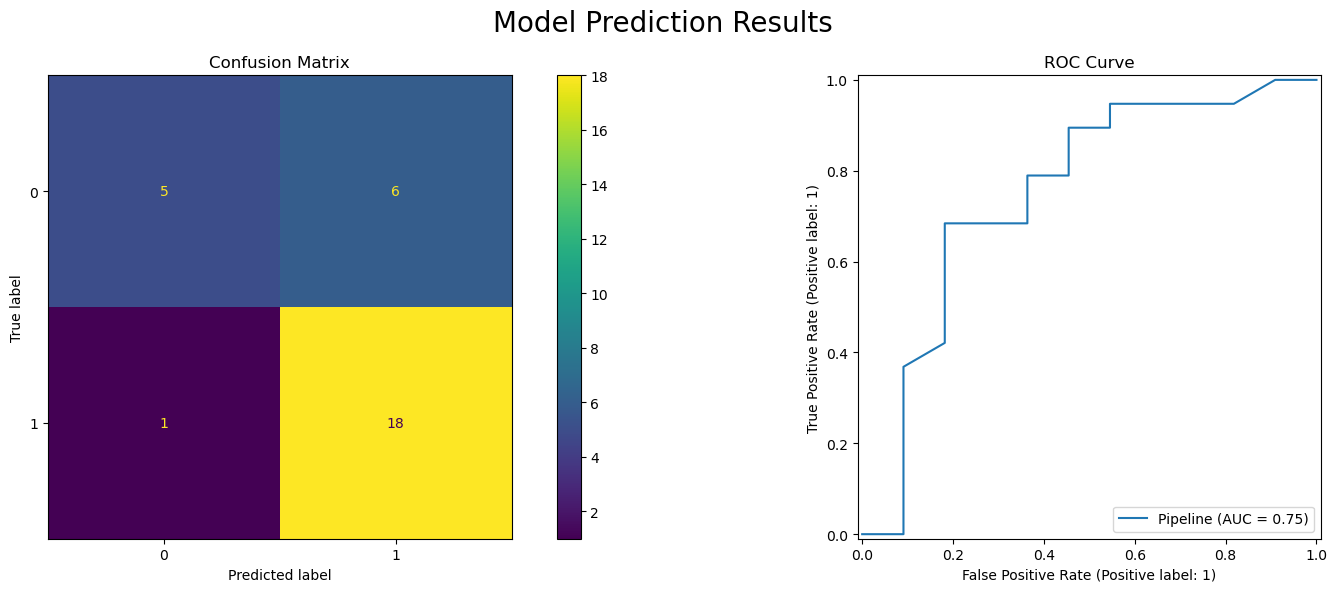

Importance
(128, 2)


,Feature,Importance
118,numeric__channel_AF8_offset,0.036088
116,numeric__channel_F6_offset,0.023056
127,numeric__channel_Iz_exponent,0.020446
80,numeric__channel_TP7_offset,0.017624
29,numeric__channel_O1_exponent,0.016027


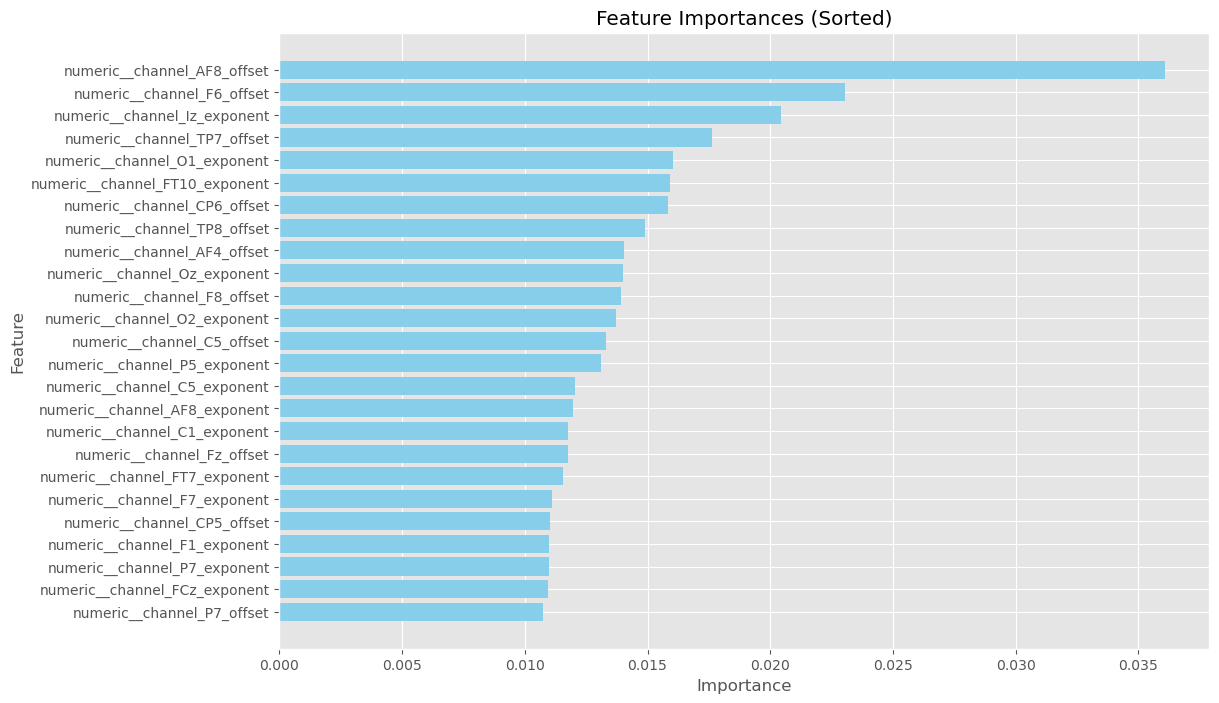

In [49]:
# Model Predictions & Evaluation
#

start_time = time.perf_counter()
y_pred = model_randforest.predict(X_test_transformed)
duration = time.perf_counter() - start_time

# Evaluate Prediction Results
print('Model Prediction Results')
print(f'Run Time: {duration:.4f}')
classification_metrics(model_randforest, X_test_transformed, y_test, y_pred)

# Feature Importance / Contribution
feature_importance(model_randforest, features_prep_pipeline)


In [50]:
# Define a prediction probability function for class 1
def model_predict(X):
    return model_randforest.predict_proba(X)[:, 1]  # For binary classification

# Select a small background dataset (e.g., 100 samples)
background = X_train_transformed[np.random.choice(X_train_transformed.shape[0], 100, replace=False)]

# Now use KernelExplainer
explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(X_test_transformed)

# Get mean absolute SHAP values for global importance
global_importance = np.abs(shap_values).mean(axis=0)
feature_ranking = np.argsort(global_importance)[::-1]
print("Top 5 features by SHAP importance:")
for i in feature_ranking[:5]:
    print(f"Feature {i}: {global_importance[i]:.4f}")
    # Get feature names for the transformed data
print("Top 5 features by name and SHAP importance:")
for idx in feature_ranking[:5]:
    print(f"{feature_names[idx]}: {global_importance[idx]:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Top 5 features by SHAP importance:
Feature 118: 0.0292
Feature 116: 0.0173
Feature 40: 0.0109
Feature 106: 0.0098
Feature 120: 0.0097
Top 5 features by name and SHAP importance:
numeric__channel_AF8_offset: 0.0292
numeric__channel_F6_offset: 0.0173
numeric__channel_CP6_offset: 0.0109
numeric__channel_TP8_offset: 0.0098
numeric__channel_AF4_offset: 0.0097


## TBD - Prediction probabilities to reduce false positives

In [ ]:

# Using predict() - returns class labels
predictions = model_randforest.predict(X_test_transformed)
print(predictions)  # Output: [1, 0, 1, 0, 1, ...]

# Using predict_proba() - returns probabilities
probabilities = model_randforest.predict_proba(X_test_transformed)
print(probabilities[:10])  # First 5 samples
# Output: [[0.000, 1.000],  # 100% confident it's class 1
#          [0.830, 0.170],  # 83% confident it's class 0
#          [0.010, 0.990],  # 99% confident it's class 1
#          [0.940, 0.060],  # 94% confident it's class 0
#          [0.220, 0.780]]  # 78% confident it's class 1

In [ ]:
def make_predictions_custom_threshold(model, X, threshold=0.5):
    """
    Make predictions with custom threshold to minimize false positives
    Higher threshold = fewer false positives, but potentially lower recall
    """
    probabilities = model.predict_proba(X)
    predictions = (probabilities[:, 1] >= threshold).astype(int)
    return predictions, probabilities


predictions, probabilities = make_predictions_custom_threshold(
    model_randforest, X_test_transformed, threshold=0.65
)

print(predictions)
print(probabilities[:10])

classification_metrics(model_randforest, X_test_transformed, y_test, predictions)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

In [ ]:
from sklearn.metrics import precision_score, recall_score

def find_optimal_threshold(model, X, y_true, metric='precision'):
    """Find threshold that optimizes a specific metric"""
    probabilities = model.predict_proba(X)[:, 1]
    thresholds = np.arange(0.1, 1.0, 0.05)
    
    best_threshold = 0.5
    best_score = 0
    
    for threshold in thresholds:
        preds = (probabilities >= threshold).astype(int)
        
        if metric == 'precision':
            score = precision_score(y_true, preds, zero_division=0)
        elif metric == 'recall':
            score = recall_score(y_true, preds, zero_division=0)
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    return best_threshold, best_score

best_theshold, best_score = find_optimal_threshold(model_randforest, X_test_transformed,y_test)
print(best_theshold, best_score)

## Logistic Regression

In [ ]:
# Logistic Regression

# Pipeline, params & grid search define
model_pipeline = Pipeline([
    ('classifier', LogisticRegression(random_state=42))
    ])

grid_params = {
    'classifier__solver': ['saga', 'lbfgs', 'liblinear'],           # Default is lbfgs. Saga with L1 or l2. Large dataset. liblinear small datasets, binary classifications
    'classifier__penalty': ['l2'],               # Default L2. L1 or L2 regularisation. Only L2 with Lbfgs
    'classifier__C': [0.1, 1, 5, 10],                # Default is 1. Strength of regularisation, smaller is stronger
    # 'logisticregression__class_weight': [None, 'balanced'],    # Tries to adjust classes that are imbalanced .... search gives non, but balanced seems better
    'classifier__class_weight': ['balanced'],           # Default None. Balanced seems to prevent near zero True predictions
    'classifier__max_iter': [5000]                      # Default 100. ??? iterations seems to be sufficient
}
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# # Straight k-fold cross-validation
# grid_search = GridSearchCV(
#     model_pipeline, grid_params, cv=5, n_jobs=-1,
#     scoring='precision'
#     )

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    model_pipeline, grid_params, cv=skf, n_jobs=-1,
    scoring='precision'
    )

# Grid search run
start_time = time.perf_counter()
grid_search.fit(X_train_transformed, y_train)
duration = time.perf_counter() - start_time

# Checkpoint - Model Training Details
ml_model_pipeline_details(model_pipeline)
print('\n')
grid_search_results(grid_search, duration)
print(f'Best Model: \n{grid_search.best_estimator_}')

# Retain the best model & save it, as well aas the grid search
model_logreg = grid_search.best_estimator_

cloudpickle.dump(grid_search, open(run_results_path + '/' + 'grid_search_logreg.pkl', 'wb'))
cloudpickle.dump(model_logreg, open(run_results_path + '/' + 'model_logreg.pkl', 'wb'))


In [ ]:
# Model Predictions & Evaluation
#

start_time = time.perf_counter()
y_pred = model_logreg.predict(X_test_transformed)
duration = time.perf_counter() - start_time

# Evaluate Prediction Results
print('Model Prediction Results')
print(f'Run Time: {duration:.4f}')
classification_metrics(model_logreg, X_test_transformed, y_test, y_pred)

# Feature Importance / Contribution
# feature_importance(model_logreg, features_prep_pipeline)

In [ ]:
# Model Predictions & Evaluation - With Thresholds
#

start_time = time.perf_counter()
y_pred = model_logreg.predict(X_test_transformed)
y_pred_prob = model_logreg.predict_proba(X_test_transformed)[:,1]
pred_threshold = 0.6
y_pred_threshold = (y_pred_prob > pred_threshold).astype(int)
duration = time.perf_counter() - start_time

# for i in range(25):
#     print(f' Binary: {y_pred[i]} vs Prob: {y_pred_prob[i]:.2f} vs {y_pred_threshold[i]}')

# Evaluate Prediction Results
print('Model Prediction Results')
print(f'Run Time: {duration:.4f}')
classification_metrics(model_logreg, X_test_transformed, y_test, y_pred_threshold)

## MLP Classifier

In [ ]:
# MLP Classifier

# Pipeline, params & grid search define
model_pipeline = Pipeline([
    ('classifier', MLPClassifier(random_state=42))
    ])

grid_params = {
    'classifier__hidden_layer_sizes': [(25, 5)],             # Default, single layer of 100
    'classifier__activation': ['tanh'],                      # Default: relu
    'classifier__alpha': [0.1],                              # default is L2, 0.0001,
    'classifier__max_iter': [500]                            # Default 200
}

# # Straight k-fold cross-validation
# grid_search = GridSearchCV(
#     model_pipeline, grid_params, cv=5, n_jobs=-1,
#     scoring='precision'
#     )

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    model_pipeline, grid_params, cv=skf, n_jobs=-1,
    scoring='precision'
    )

# Grid search run
start_time = time.perf_counter()
grid_search.fit(X_train_transformed, y_train)
duration = time.perf_counter() - start_time

# Checkpoint - Model Training Details
ml_model_pipeline_details(model_pipeline)
print('\n')
grid_search_results(grid_search, duration)
print(f'Best Model: \n{grid_search.best_estimator_}')

# Retain the best model & save it, as well aas the grid search
model_mlpc = grid_search.best_estimator_

cloudpickle.dump(grid_search, open(run_results_path + '/' + 'grid_search_mlpc.pkl', 'wb'))
cloudpickle.dump(model_mlpc, open(run_results_path + '/' + 'model_mlpc.pkl', 'wb'))

In [ ]:
# Model Predictions & Evaluation
#

start_time = time.perf_counter()
y_pred = model_mlpc.predict(X_test_transformed)
duration = time.perf_counter() - start_time

# Evaluate Prediction Results
print('Model Prediction Results')
print(f'Run Time: {duration:.4f}')
classification_metrics(model_mlpc, X_test_transformed, y_test, y_pred)

# Feature Importance / Contribution
# feature_importance(model_mlpc, features_prep_pipeline)

In [ ]:
# Model Predictions & Evaluation - With Thresholds
#

start_time = time.perf_counter()
y_pred = model_mlpc.predict(X_test_transformed)
y_pred_prob = model_mlpc.predict_proba(X_test_transformed)[:,1]
pred_threshold = 0.6
y_pred_threshold = (y_pred_prob > pred_threshold).astype(int)
duration = time.perf_counter() - start_time

# for i in range(25):
#     print(f' Binary: {y_pred[i]} vs Prob: {y_pred_prob[i]:.2f} vs {y_pred_threshold[i]}')

# Evaluate Prediction Results
print('Model Prediction Results')
print(f'Run Time: {duration:.4f}')
classification_metrics(model_mlpc, X_test_transformed, y_test, y_pred_threshold)

In [ ]:
import shap


In [ ]:

# SHAP explainer for the neural network
explainer = shap.Explainer(model_mlpc, X_train_transformed)
shap_values = explainer(X_train_transformed)

# Compute mean absolute SHAP values (global importance)
global_importance = np.abs(shap_values.values).mean(axis=0)
feature_ranking = np.argsort(global_importance)[::-1]

# Print top 5 features
for i in feature_ranking[:5]:
    print(f"Feature {i} Global Importance: {global_importance[i]:.4f}")

In [47]:
# Define a prediction probability function for class 1
def model_predict(X):
    return model_mlpc.predict_proba(X)[:, 1]  # For binary classification

# Select a small background dataset (e.g., 100 samples)
background = X_train_transformed[np.random.choice(X_train_transformed.shape[0], 100, replace=False)]

# Now use KernelExplainer
explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(X_test_transformed)

# Get mean absolute SHAP values for global importance
global_importance = np.abs(shap_values).mean(axis=0)
feature_ranking = np.argsort(global_importance)[::-1]
print("Top 5 features by SHAP importance:")
for i in feature_ranking[:5]:
    print(f"Feature {i}: {global_importance[i]:.4f}")
    # Get feature names for the transformed data
print("Top 5 features by name and SHAP importance:")
for idx in feature_ranking[:5]:
    print(f"{feature_names[idx]}: {global_importance[idx]:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Top 5 features by SHAP importance:
Feature 79: 0.0592
Feature 119: 0.0345
Feature 37: 0.0260
Feature 118: 0.0210
Feature 20: 0.0207
Top 5 features by name and SHAP importance:
numeric__channel_C5_exponent: 0.0592
numeric__channel_AF8_exponent: 0.0345
numeric__channel_P8_exponent: 0.0260
numeric__channel_AF8_offset: 0.0210
numeric__channel_CP5_offset: 0.0207


# Run: 4. Models Training with Combined Grid Search

In [ ]:
# Establish a Model Pipeline - With Features Search
#

# Pipeline, params & grid search define
model_pipeline = Pipeline([
    ('features_select', FeatureSelection()),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, verbose=False))
    ])

grid_params = {
    'features_select__features_detail_level': ['region', 'channel'],
    'features_select__selected_features': [['exp', 'offset'], ['cf', 'pw']],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],     # Default gini. Tree split evaluation function
    'classifier__n_estimators': [150, 175],                       # Default 100. Number of trees
    'classifier__max_depth': [2, 10, None],                       # Default none, unlimited
    'classifier__max_leaf_nodes': [50, None],                     # Default none, unlimited
    # 'randomforestclassifier__min_samples_split': [2, 5],
    # 'classifier__class_weight': [None, 'balanced']
                            # Balanced gives more importance to minority classes ... ?? Improves recall at the expense of precision
    } 

# grid_search = GridSearchCV(
#     model_pipeline, grid_params, 
#     cv=5,
#     scoring='f1'
#     )

# Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    model_pipeline, grid_params, cv=skf, n_jobs=-1,
    scoring='precision'
    )

# Grid search run

start_time = time.perf_counter()
grid_search.fit(X_train, y_train)
duration = time.perf_counter() - start_time

# Checkpoint - Model Training Details
ml_model_pipeline_details(model_pipeline)
print('\n')
grid_search_results(grid_search, duration)
print(f'Best Model: \n{grid_search.best_estimator_}')

model_randforest_widesearch = grid_search.best_estimator_



In [ ]:
# Model Predictions & Evaluation
#
model_randforest = grid_search.best_estimator_

start_time = time.perf_counter()
y_pred = model_randforest.predict(X_test)
duration = time.perf_counter() - start_time

# Evaluate Prediction Results
print('Model Prediction Results')
print(f'Run Time: {duration:.4f}')
classification_metrics(model_randforest, X_test, y_test, y_pred)

# Feature Importance / Contribution
# feature_importance(model_randforest, features_prep_pipeline)
